In [1]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN import *
from NN_library.train_dual_PINN import *
from NN_library.MN.material_NN import *
from matplotlib.tri import Triangulation
import utility 
%load_ext autoreload
%autoreload 2

Using device: cuda
Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

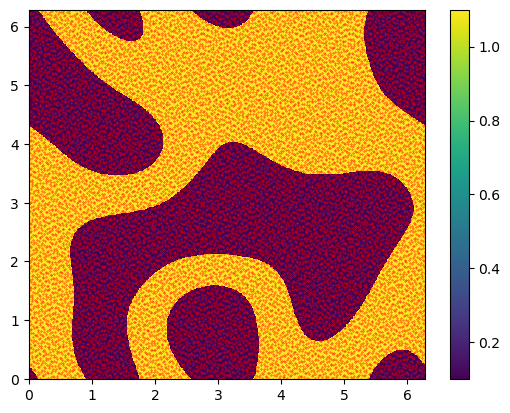

In [20]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

model = gs.Gaussian(dim=2, var=1, len_scale=1.5)

srf = gs.SRF(
    model,
    generator="Fourier",
    period=L,
    mode_no=32,
    seed=2,
)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = 0.1 + np.floor(srf((x, y))) % 2
    return a

_, x = next(enumerate(loaders['train']))
a_numpy = a_function(x[:,0], x[:,1])
a_torch = torch.tensor(a_numpy, device=dev, dtype=torch.float).view(-1,1,1)

mat_epoch = 29999
args = {'dev' : dev, 'name' : f'NN_library/MN/MN_270'}
mat_NN = Material_NN()
mat_NN = load_network(mat_NN, args['name']+f'_{mat_epoch}', args)
mat_NN = mat_NN.to(dev)

def A_interp(x):
    a = 0.1+mat_NN(x)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    a = 0.1+mat_NN(x)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a).view(-1,1,1) * I
    return A

def A(x):
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a_torch * I
    return A

def A_inv(x):  
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a_torch).view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Primal PINN

In [4]:
net_primal = PINN(n_periodic=5, n_hidden=10, n_layers=2, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/gauss/PINN_primal_{mat_epoch}_{total_params}'}

Number of parameters: 391


In [ ]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [5]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  1.31068687e+01, bound:  6.39766097e-01
Epoch: 1 mean train loss:  1.31001053e+01, bound:  6.39782548e-01
Epoch: 2 mean train loss:  1.30933447e+01, bound:  6.39798999e-01
Epoch: 3 mean train loss:  1.30865860e+01, bound:  6.39815331e-01
Epoch: 4 mean train loss:  1.30798321e+01, bound:  6.39831662e-01
Epoch: 5 mean train loss:  1.30730791e+01, bound:  6.39847994e-01
Epoch: 6 mean train loss:  1.30663309e+01, bound:  6.39864266e-01
Epoch: 7 mean train loss:  1.30595865e+01, bound:  6.39880419e-01
Epoch: 8 mean train loss:  1.30528440e+01, bound:  6.39896572e-01
Epoch: 9 mean train loss:  1.30461044e+01, bound:  6.39912605e-01
Epoch: 10 mean train loss:  1.30393686e+01, bound:  6.39928579e-01
Epoch: 11 mean train loss:  1.30326347e+01, bound:  6.39944494e-01
Epoch: 12 mean train loss:  1.30259018e+01, bound:  6.39960349e-01
Epoch: 13 mean train loss:  1.30191717e+01, bound:  6.39976084e-01
Epoch: 14 mean train loss:  1.30124426e+01, bound:  6.39991879e-01
Epoch

In [7]:
np.save(f'NN_library/training_data/gauss/PINN_primal_{mat_epoch}_{total_params}', np.vstack([losses_train, losses_val]))

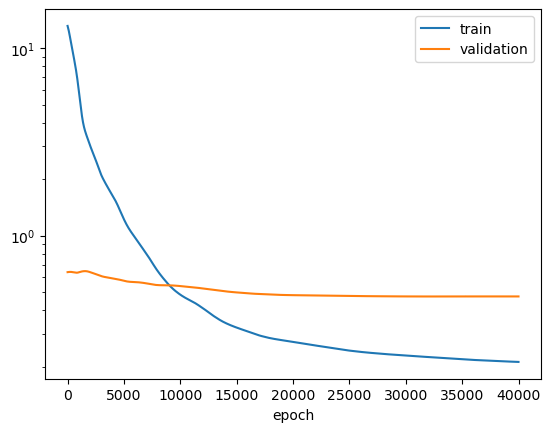

In [6]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [9]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss(x, net_primal, A, H1)
_, q2 = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_bound(areas, tri, q1, L).detach()[0].item()
bound_2 = compute_bound(areas, tri, q2, L).detach()[0].item()
print(bound_1, bound_2)

np.save(f'bounds/gauss/A_u_{mat_epoch}_PINN_{total_params}.npy', (bound_1, bound_2))

0.47495290637016296 0.4749673008918762


In [10]:
a_numpy = a_function(XY[0].flatten(), XY[1].flatten())
a_torch = torch.tensor(a_numpy, device=dev, dtype=torch.float).view(-1,1,1)

In [11]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _ = PDE_loss(grid_data, net_primal, A, H1)

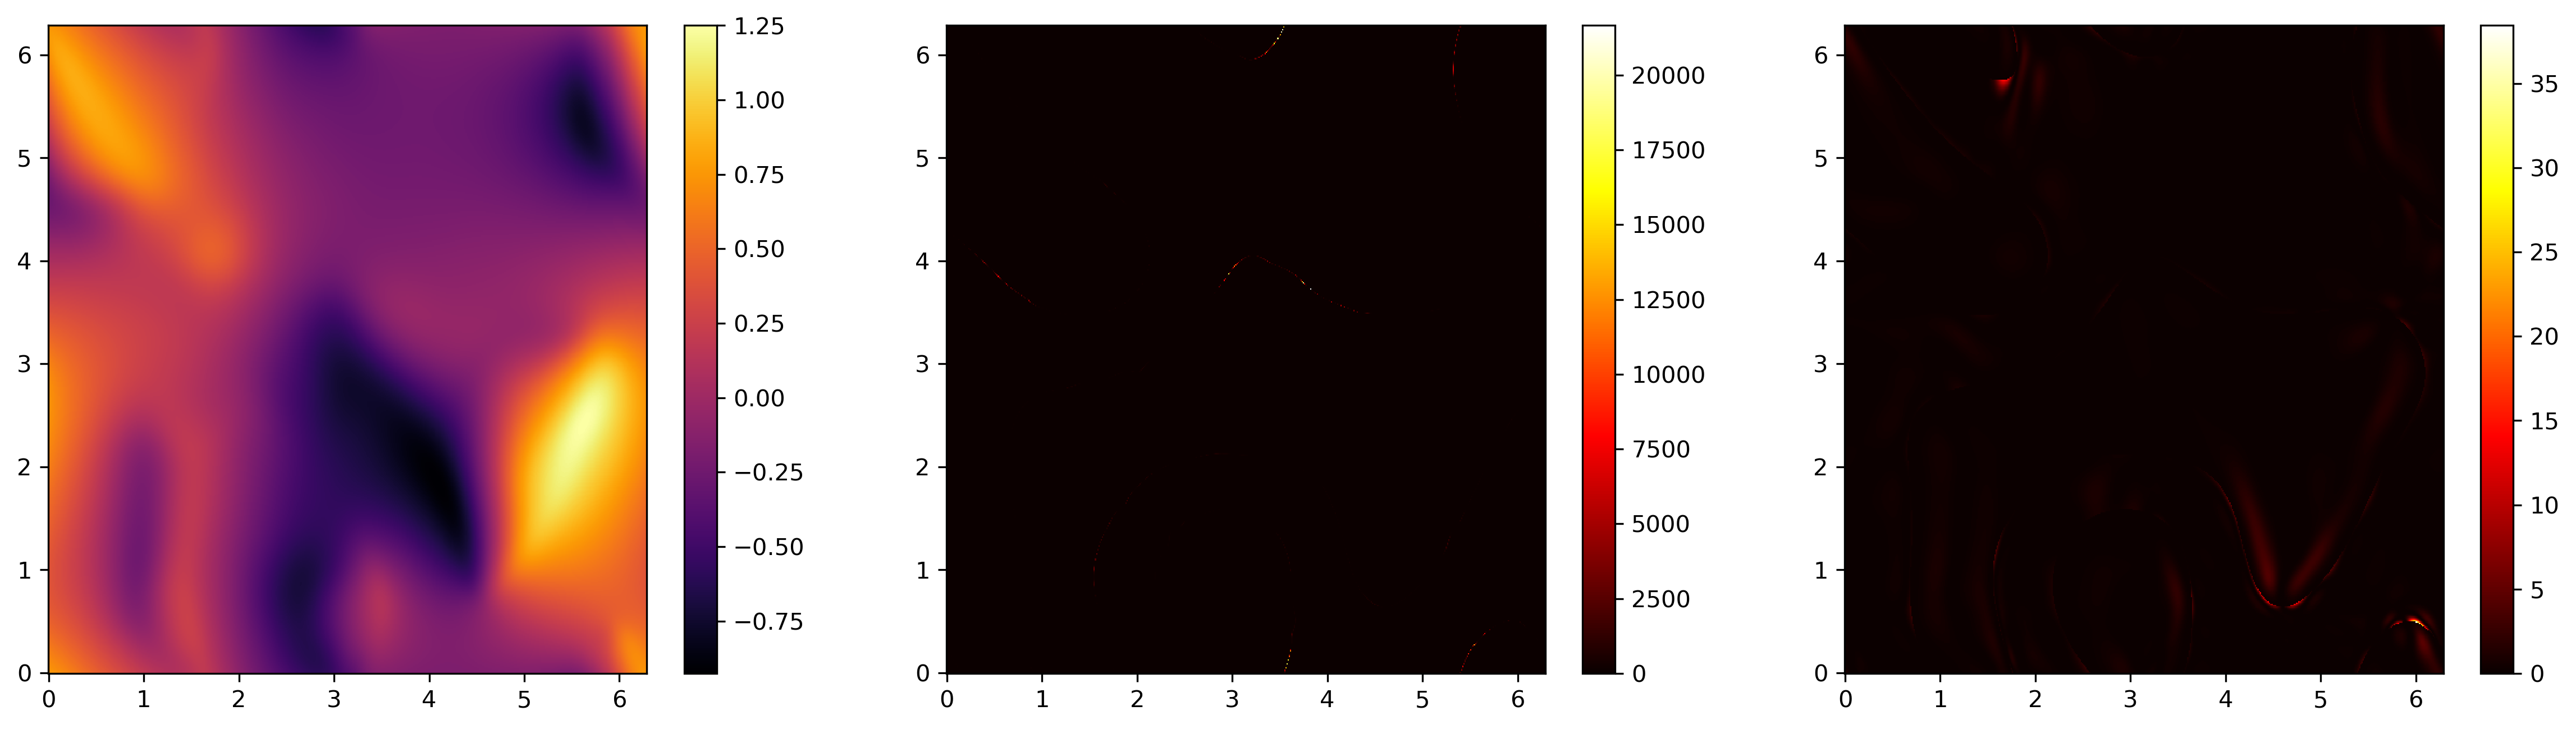

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

# Dual PINN

In [13]:
net_dual = PINN(n_periodic=5, n_hidden=10, n_layers=2, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/gauss/PINN_dual_{mat_epoch}_{total_params}'}

Number of parameters: 391


In [6]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [14]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  3.23300879e+03, bound:  1.97157726e-01
Epoch: 1 mean train loss:  3.23186353e+03, bound:  1.97156042e-01
Epoch: 2 mean train loss:  3.23072095e+03, bound:  1.97154403e-01
Epoch: 3 mean train loss:  3.22958154e+03, bound:  1.97152734e-01
Epoch: 4 mean train loss:  3.22844409e+03, bound:  1.97151080e-01
Epoch: 5 mean train loss:  3.22731030e+03, bound:  1.97149441e-01
Epoch: 6 mean train loss:  3.22617920e+03, bound:  1.97147757e-01
Epoch: 7 mean train loss:  3.22505103e+03, bound:  1.97146088e-01
Epoch: 8 mean train loss:  3.22392651e+03, bound:  1.97144419e-01
Epoch: 9 mean train loss:  3.22280493e+03, bound:  1.97142676e-01
Epoch: 10 mean train loss:  3.22168677e+03, bound:  1.97140977e-01
Epoch: 11 mean train loss:  3.22057202e+03, bound:  1.97139278e-01
Epoch: 12 mean train loss:  3.21946069e+03, bound:  1.97137564e-01
Epoch: 13 mean train loss:  3.21835303e+03, bound:  1.97135836e-01
Epoch: 14 mean train loss:  3.21724854e+03, bound:  1.97134122e-01
Epoch

In [16]:
np.save(f'NN_library/training_data/gauss/PINN_dual_{total_params}', np.vstack([losses_train, losses_val]))

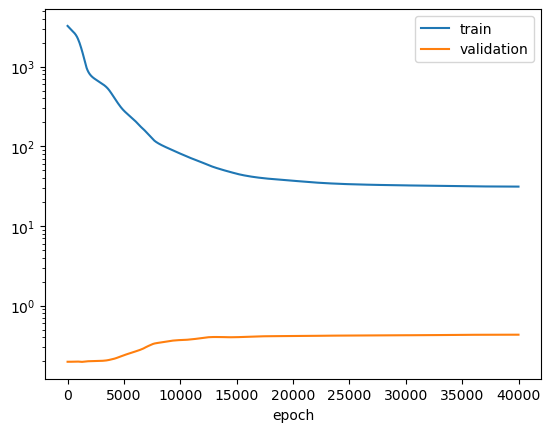

In [15]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [17]:
U2 = net_dual(grid_data).detach().cpu()
error_1, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

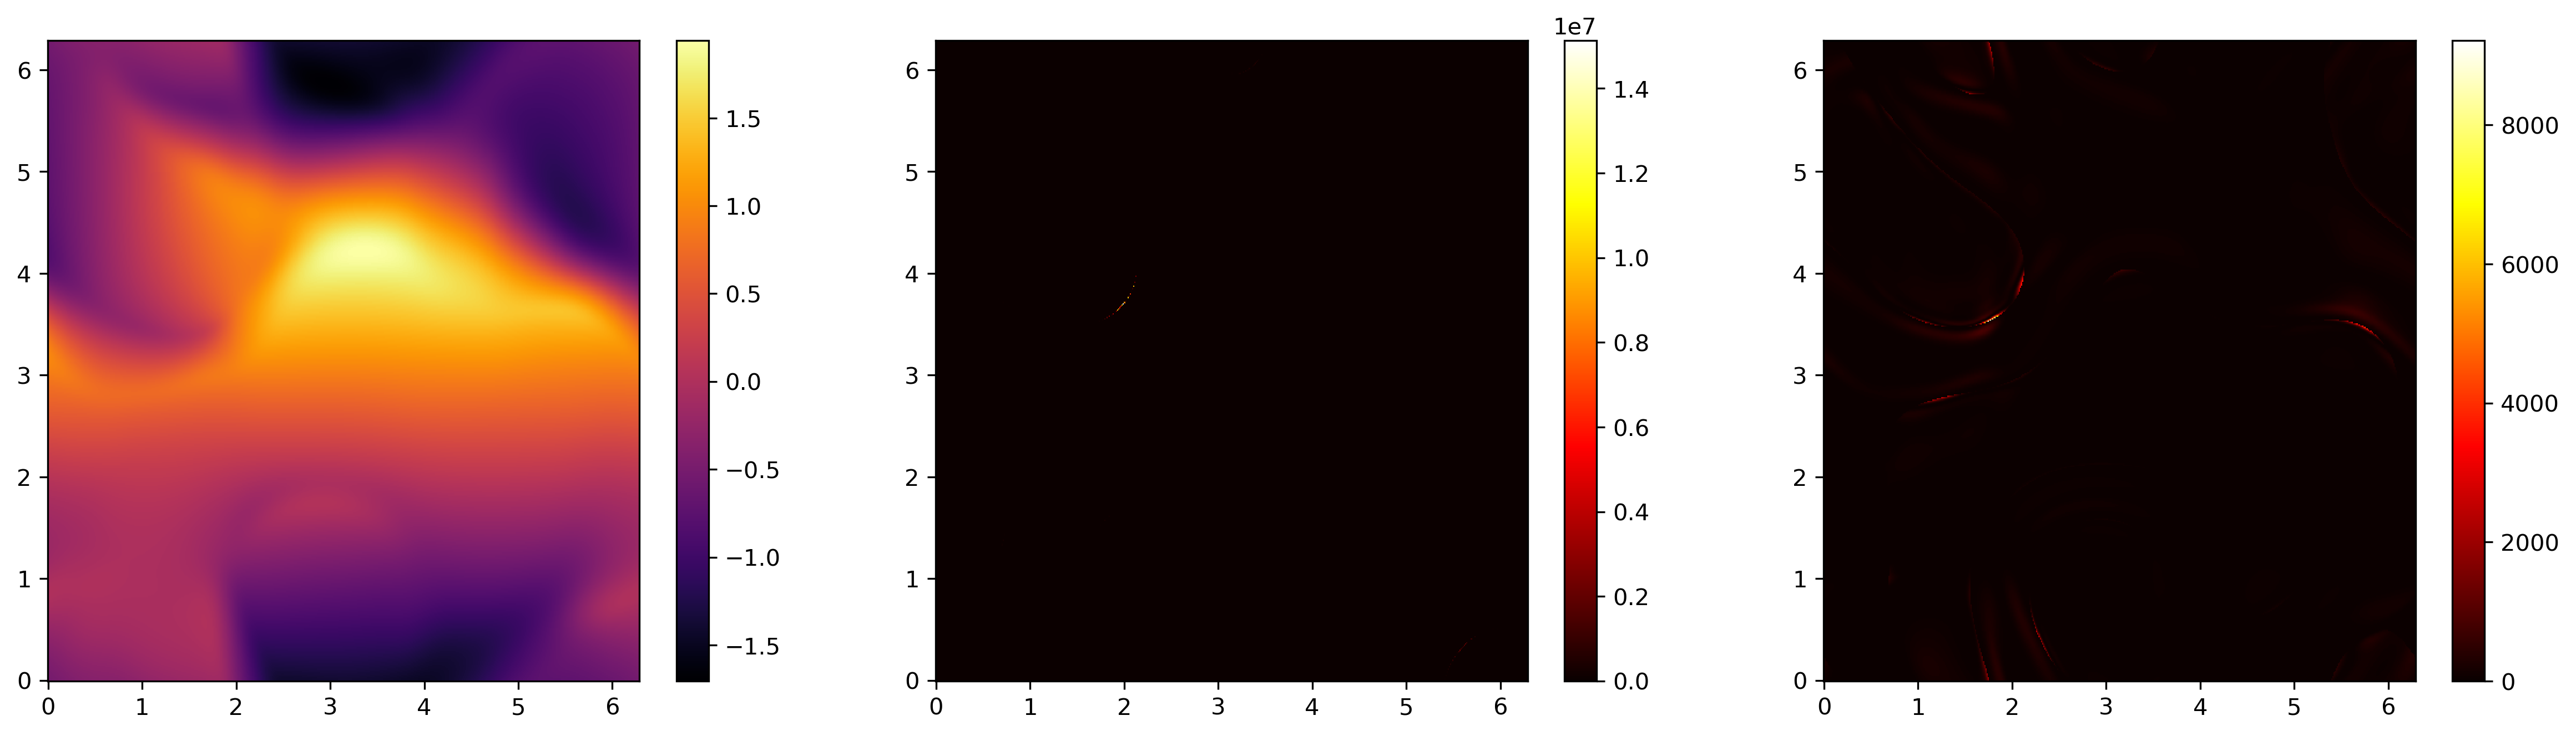

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [21]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss_dual(x, net_dual, A_inv, H1)
_, q2 = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_bound(areas, tri, q1, L).detach()
bound_2 = compute_bound(areas, tri, q2, L).detach()
bound_inv_1 = bound_1[0] / (bound_1[0]**2 - bound_1[1]**2)
bound_inv_2 = bound_2[0] / (bound_2[0]**2 - bound_2[1]**2)

print(bound_inv_1, bound_inv_2)
np.save(f'bounds/gauss/A_l_PINN_{total_params}.npy', (bound_inv_1.item(), bound_inv_2.item()))

tensor(0.4301, device='cuda:0') tensor(0.4310, device='cuda:0')
